In [1]:
# imports
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# data = np.load('../data/npy/channel_flow.npy')
data = np.load('/kaggle/input/channelflow/channel_flow.npy')

In [3]:
phi_tot = tf.expand_dims(data, axis=3)
new_phi = phi_tot[:490]
print(np.shape(new_phi))
phi_test = phi_tot[490:]

(490, 511, 127, 1)


In [4]:

# NN

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,
  decay_steps=500,
  decay_rate=0.5,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam()


def compile_and_fit1(model, name, optimizer=None, max_epochs=10000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError() ,
                metrics=[tf.keras.losses.MeanAbsoluteError()]),
                

    model.summary()

    history = model.fit(
            new_phi, new_phi,
            #steps_per_epoch = STEPS_PER_EPOCH,
            epochs=500,
            validation_split=0.1,
            callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20),
            verbose=2)

    return history



In [5]:

y = tf.keras.layers.AveragePooling2D(pool_size=(2, 2),
   padding='valid')(new_phi)
#y = tf.keras.layers.Conv2D(2, 3, padding= 'valid',activation='linear', input_shape=(127,127,))(new_phi)
print(tf.shape(y))

tf.Tensor([490 255  63   1], shape=(4,), dtype=int32)


In [6]:
NN1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(256,64,)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Reshape((256, 64, 1)),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])

# inputs      = tf.keras.Input(shape=(3,))
# outputs     = dense(inputs)
# Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

inputs      = tf.keras.Input(shape=(new_phi.shape[1:]))
#outputs     = inputs[:,0:3] + 0.01*dense(inputs)
#upscaling davanti a NN1
outputs     = NN1(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(inputs)) # +0.5*NN2(inputs)
Updatemodel = tf.keras.Model(inputs=inputs, outputs=outputs)

history = compile_and_fit1(Updatemodel, 'Lorentz')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 511, 127, 1)]     0         
                                                                 
 average_pooling2d_1 (Averag  (None, 256, 64, 1)       0         
 ePooling2D)                                                     
                                                                 
 sequential (Sequential)     (None, 511, 127, 1)       2944      
                                                                 
Total params: 2,944
Trainable params: 2,944
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
14/14 - 5s - loss: 0.5205 - mean_absolute_error: 0.6762 - val_loss: 0.4729 - val_mean_absolute_error: 0.6564 - 5s/epoch - 387ms/step
Epoch 2/500
14/14 - 0s - loss: 0.4419 - mean_absolute_error: 0.6263 - val_loss: 0.4259 - val_mean_absolute_error

1/1 [==============================] - 0s 245ms/step


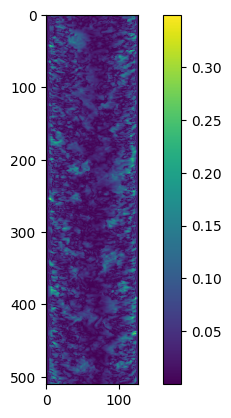

In [7]:
test_true = phi_test
test_model = history.model.predict(phi_test)

plt.imshow(np.abs(test_true[-1]-test_model[-1]))
plt.colorbar()

In [15]:
NN2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(128, 3),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2DTranspose(1, 5),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Cropping2D(((1, 0), (1, 0)))
])

mse = tf.keras.losses.MeanSquaredError()
from keras import backend as K
def custom_loss(x, y_true, y_pred):
    y_pred_1=NN1(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(x),training=False)
    a,b=0,1
    return a*K.mean(K.square(y_pred_1 - y_pred)) + b*K.mean(K.square(y_pred - y_true))
       

# lr = 1e-1
# epochs = 5

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# # Prepare the metrics.
# train_acc_metric = tf.keras.metrics.MeanAbsoluteError()

# input_nn =  new_phi
# output_nn = new_phi

# x_train = tf.convert_to_tensor(input_nn,dtype=tf.float32)
# y_train = tf.convert_to_tensor(output_nn,dtype=tf.float32)

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(input_nn.shape[0]//2)#.batch(input_nn.shape[0])

# epoch_adam = epochs

# @tf.function
# def train_step(x, y):
#     with tf.GradientTape() as tape:
#         pred = NN2(x, training=True)
#         loss = my_loss(y, pred, x)
#     grads = tape.gradient(loss, NN2.trainable_weights)
#     optimizer.apply_gradients(zip(grads, NN2.trainable_weights))
#     return loss

# for epoch in range(epoch_adam):
#     if epoch % 10 ==0:
#         print("Start of epoch %d" % (epoch))

#     # Iterate over the batches of the dataset.
#     for x_batch_train, y_batch_train in train_dataset:
#         loss= train_step(x_batch_train, y_batch_train)
#         # appendete loss a vettore per postprocess
#         tf.print(loss)  


In [16]:

inputs = tf.keras.Input(shape=new_phi.shape[1:])

outputs = NN2(inputs)
model = tf.keras.Model(inputs, outputs)
model.add_loss(custom_loss(inputs, inputs, outputs))
model.compile(optimizer=tf.keras.optimizers.Adadelta(1),
            loss=None,
            metrics=[tf.keras.losses.MeanAbsoluteError()]),


model.summary()

full_nn = model.fit(
        new_phi, new_phi,
        #steps_per_epoch = STEPS_PER_EPOCH,
        epochs=500,
        validation_split=0.1,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True),
        verbose=2)



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 511, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 511, 127, 1)  615713      ['input_3[0][0]']                
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 256, 64, 1)  0           ['input_3[0][0]']                
 oling2D)                                                                                         
                                                                                            

In [17]:

# inputs      = tf.keras.Input(shape=(new_phi.shape[1:]))
# #outputs     = inputs[:,0:3] + 0.01*dense(inputs)
# #upscaling davanti a NN1
# outputs     = 0.5*NN1(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same')(inputs)) + 0.5*NN2(inputs)

In [18]:
test_true = phi_test
test_model = full_nn.model.predict(phi_test)

1/1 [==============================] - 0s 321ms/step


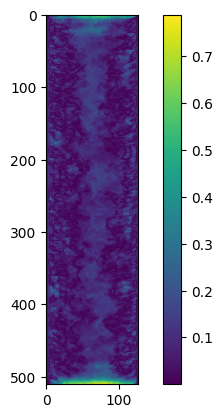

In [19]:
plt.imshow(np.abs(test_true[-1]-test_model[-1]))
plt.colorbar()

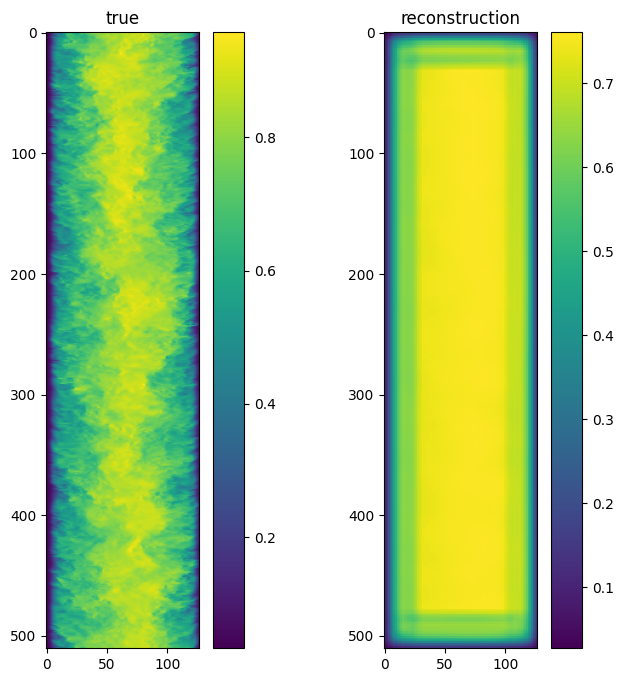

In [20]:
ind = -1
fig,axs = plt.subplots(1,2,figsize=(8,8))
im = axs[0].imshow(test_true[ind])
axs[0].set_title('true')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(test_model[ind])
axs[1].set_title('reconstruction')
plt.colorbar(im, ax=axs[1])

In [21]:
print(test_model[-1])

[[[0.0337821 ]
  [0.03002259]
  [0.03002259]
  ...
  [0.05052545]
  [0.04546341]
  [0.04546341]]

 [[0.04290083]
  [0.04407032]
  [0.04407032]
  ...
  [0.08283935]
  [0.05670062]
  [0.05670062]]

 [[0.04290083]
  [0.04407032]
  [0.04407032]
  ...
  [0.08283935]
  [0.05670062]
  [0.05670062]]

 ...

 [[0.03781863]
  [0.05997889]
  [0.05997889]
  ...
  [0.08601034]
  [0.05655026]
  [0.05655026]]

 [[0.02734899]
  [0.04339739]
  [0.04339739]
  ...
  [0.06342808]
  [0.04893427]
  [0.04893427]]

 [[0.02734899]
  [0.04339739]
  [0.04339739]
  ...
  [0.06342808]
  [0.04893427]
  [0.04893427]]]
